# Fitting single flow curve

This notebook contains a list scripts focusing on analysis and visualization of a single flow curve. A flow curve is the measurement of the viscosity as a function of shear rate. In a measurment a constant shear rate is imposed on a fluid sample and the required shear stress is measured. 

Since for Non newtonian fluids the viscosity is a function of the shear rate, the flow curve measurement is a way to characterize such functional dependence. 

Rheological models can be used to fit the flow curve and extract parameters that in some case directly relates to fundamental material properties.

In this notebook we provide some example of analysis of flow curves using powerful python libraries that we simply integrate to make flow curves analysis simple, easy to share and reproduce.

We provide a sequence of exaples structured as "recepies" each with a specific scope, plotting data, fitting data, evaluating confidence itervals...

Each recepy can be considered "stand alone" meaning that the only objects that cells share are the general imports in the first cell and the functions defined through the notebook. This should make it easy to copy and paste a cell in case you want to use it as a starting point for your own analysis.

If you have a google account you can run this documentation notebook [Open in colab](https://colab.research.google.com/github/rheopy/rheofit/blob/master/docs/source/Fitting_single_flow_curve.ipynb)

In [1]:
#executing the notebook in colab requires installation of the rheofit library
!pip install git+https://github.com/marcocaggioni/rheofit.git

  Cloning https://github.com/marcocaggioni/rheofit.git to /tmp/pip-req-build-d_2i_lum
  Running command git clone -q https://github.com/marcocaggioni/rheofit.git /tmp/pip-req-build-d_2i_lum
     |████████████████████████████████| 256kB 4.7MB/s 
     |████████████████████████████████| 61kB 18.0MB/s 
     |████████████████████████████████| 61kB 20.3MB/s 
     |████████████████████████████████| 235kB 44.2MB/s 
  Created wheel for rheofit: filename=rheofit-0.1.0-cp36-none-any.whl size=7709 sha256=933d033056262ac61dbadabd29c926617565922174fc07a3e4ccc189e2ed23ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-aiw7jkan/wheels/f3/49/bb/fc1b0ac0a312efb9b4a46588084075de022a26ac00c8cf1193
  Created wheel for lmfit: filename=lmfit-0.9.14-cp36-none-any.whl size=88612 sha256=dc1bc62332b6dd751e3b82ffd630d9ae61f38b7d679f488f21d433a8bb89fd03
  Stored in directory: /root/.cache/pip/wheels/a2/ad/74/1efa3d8294126064517e79592df763b8f30e010c18fadf2d6a
  Created wheel for corner: filename=corner-2.0.1-cp36

In [0]:
%matplotlib inline

import sys
sys.path.append("./../") #in case you are running the notebook in binder or from the cloned repository
import rheofit
import lmfit
import pybroom as pb
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
import seaborn

## Getting Example flow curve data

To make demonstration simple we stored an example flow curve in the rheodata module. In the future we would like to collect flow curves from published works to make them easily available for training purpouse. 

The data provided refer to a 75w% mineral oil in 11%LAS surfactant solution. The emusion droplets size ranges from 1-10 um and the measurement was performed with a Couette geometry at 40C.

The example_emulsion method returns a Pandas dataframe with column 'Shear rate' in [1/s] and column 'Stress' in [Pa]. The choice of the name convention is from the excel exported file by the TA Trios software. A possibly better choice could be the RheoML convention 'ShearRate' and 'ShearStress'.

Example of importing data from different file formats are provided in a different Notebook, here we focus on possible analysis and visualization on a single flow curve.

In [3]:
#using provided example data
example_data=rheofit.rheodata.example_emulsion()
example_data.head()

,Shear rate,Stress
0,999.89475,131.22475
1,891.25100,121.57225
2,794.32825,112.56525
3,707.94600,104.25800
4,630.95750,96.58295


## Plotting flow curve data
To plot the data we use matplolib. We define a simple function that plot the data, set x and y scale to log and the label for x and y. The function return a matplolib figure object that can be stored in a variable.

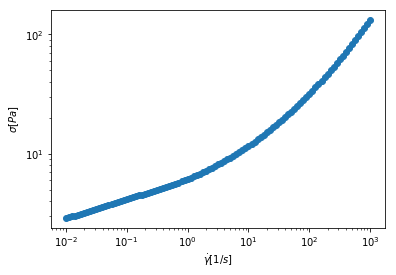

In [4]:
data=rheofit.rheodata.example_emulsion()

def plot_data(data):
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('$\sigma [Pa]$');
    plt.xlabel('$\dot\gamma [1/s]$');
    
    return plt.gcf()

fig1=plot_data(data);

## Fitting flow curve data to a rheological model
This is the most important functionality mostly provided by the [LMFIT](https://lmfit.github.io/lmfit-py/) library. The rheofit module just provide the rheology model definition and documentation. 

For example a popular model for yield stress fluids is the Hershel Bulckley model is a lmfit.Model object

In [5]:
rheofit.models.HB_model

<lmfit.Model: Model(HB, prefix='HB_')>

The model object is based on the function rheofit.models.HB

In [6]:
help(rheofit.models.HB)

Help on function HB in module rheofit.models:

HB(x, ystress=1.0, K=1.0, n=0.5)
    Hershel-Bulkley Model
    
    Note:
    
    .. math::
       \sigma= \sigma_y + K \cdot \dot\gamma^n
    
    Args:
        ystress: yield stress [Pa]
    
        K : Consistency index [Pa s^n]
    
        n : Shear thinning index []
    
    Returns:
        stress : Shear Stress, [Pa]



To fit the data we use the fit method of the model object passing the **stress**, the **shear rate** and the weights

In [7]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))
res_fit

## Plotting Fit results

The fit method returns a fit result object that contains all the information on the data, the model used and the results

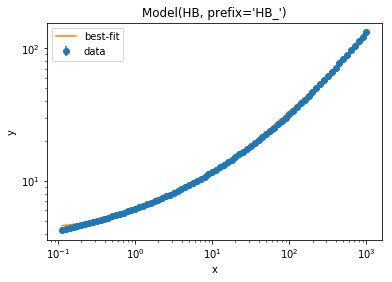

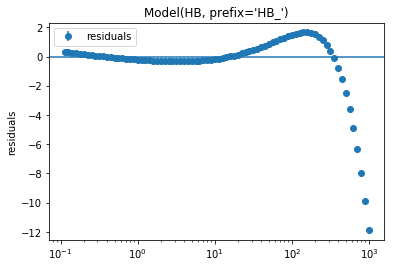

In [8]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']*0.1))

kwarg={'xscale':'log','yscale':('log')}
res_fit.plot_fit(ax_kws=kwarg,yerr=False);
plt.figure()
res_fit.plot_residuals(yerr=False,ax_kws={'xscale':'log'})

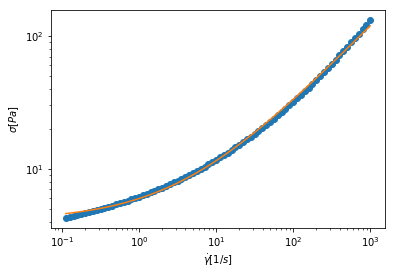

In [9]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]

model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

def plot_fit(res_fit, xlist=None):
    if xlist is None:
        xlist=res_fit.userkws['x']
    
    plt.plot(res_fit.userkws['x'], res_fit.data,'o',label='Data')
    plt.plot(xlist, res_fit.eval(x=xlist),label='Best fit')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('$\sigma [Pa]$')
    plt.xlabel('$\dot\gamma [1/s]$')

plot_fit(res_fit);

## Explore fit results with pybroom
Exploring the lmfit.fit_result object is not intuitive, using the convenient [pybroom](https://pybroom.readthedocs.io/en/stable/) library make things very easy, especially when we explore lists of results from different sample. 

In [10]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

pb.glance(res_fit)

,model,method,num_params,num_data_points,chisqr,redchi,AIC,BIC,num_func_eval,success,message
0,"Model(HB, prefix='HB_')",leastsq,3,101,0.523638,0.005343,-525.469582,-517.624221,29,True,Fit succeeded.


In [11]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

pb.tidy(res_fit)

,name,value,min,max,vary,expr,stderr,init_value
0,HB_K,2.562815,0,inf,True,NaN,0.091189,1.0
1,HB_n,0.539288,0,1.0,True,NaN,0.007523,0.5
2,HB_ystress,3.186295,0,inf,True,NaN,0.062969,1.0


In [12]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

augmented=pb.augment(res_fit)
augmented.head()

,x,data,best_fit,residual
0,999.89475,131.22475,109.492113,-0.165614
1,891.25100,121.57225,103.098212,-0.151959
2,794.32825,112.56525,97.083545,-0.137535
3,707.94600,104.25800,91.430975,-0.123032
4,630.95750,96.58295,86.118672,-0.108345


## Plot residuals

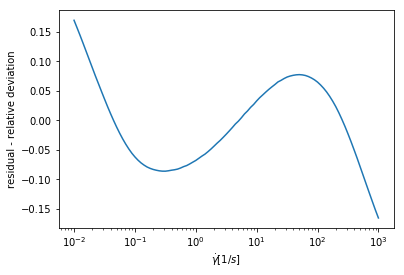

In [13]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def plot_residuals(res_fit):
    augmented=pb.augment(res_fit)
    plt.plot('x','residual',data=augmented)
    plt.xscale('log')
    plt.ylabel('residual - relative deviation');
    plt.xlabel('$\dot\gamma [1/s]$');
    
    return plt.gcf()

plot_residuals(res_fit);

## Confidence interval

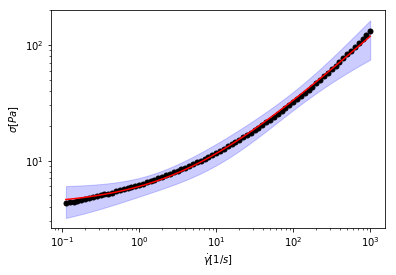

In [14]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

def plot_confidence(res_fit,expand=10):
    dely = res_fit.eval_uncertainty(x=res_fit.userkws['x'],sigma=3)*expand
    
    plt.plot(res_fit.userkws['x'], res_fit.data,'o',color='black',label='Data',markersize=5)
    plt.plot(res_fit.userkws['x'], res_fit.best_fit,label='Best fit TC model',color='red')
    plt.fill_between(res_fit.userkws['x'], res_fit.best_fit-dely,res_fit.best_fit+dely,
                     color='blue',alpha=0.2,label='0.9973 Confidence interval')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('$\sigma [Pa]$')
    plt.xlabel('$\dot\gamma [1/s]$')
    
    return plt.gcf()

plot_confidence(res_fit);

## Fit specific shear rate range

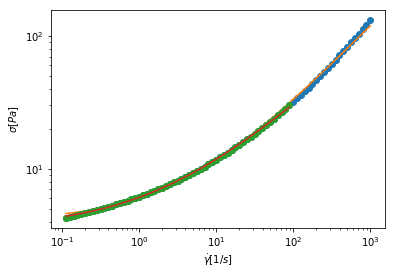

In [15]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

min_shear_rate=0.1
max_shear_rate=1000

def fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=100):
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)
    res_fit=model.fit(data[mask]['Stress'],x=data[mask]['Shear rate'],weights=1/(data[mask]['Stress']))
    
    return res_fit

plot_fit(res_fit);
plot_fit(fit_range(res_fit));

In [16]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))

min_shear_rate=0.1
max_shear_rate=1000

def fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=100):
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    mask=(data['Shear rate']>min_shear_rate) & (data['Shear rate']<max_shear_rate)
    res_fit=model.fit(data[mask]['Stress'],x=data[mask]['Shear rate'],weights=1/(data[mask]['Stress']))
    
    return res_fit

display(pb.tidy(fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=10)))
display(pb.tidy(fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=100)))
display(pb.tidy(fit_range(res_fit,min_shear_rate=0.1,max_shear_rate=1000)))

,name,value,min,max,vary,expr,stderr,init_value
0,HB_K,2.946032,0,inf,True,NaN,0.033507,1.0
1,HB_n,0.452852,0,1.0,True,NaN,0.004298,0.5
2,HB_ystress,3.219395,0,inf,True,NaN,0.028909,1.0


,name,value,min,max,vary,expr,stderr,init_value
0,HB_K,2.498040,0,inf,True,NaN,0.037762,1.0
1,HB_n,0.517414,0,1.0,True,NaN,0.003954,0.5
2,HB_ystress,3.589250,0,inf,True,NaN,0.034026,1.0


,name,value,min,max,vary,expr,stderr,init_value
0,HB_K,1.880492,0,inf,True,NaN,0.051488,1.0
1,HB_n,0.595807,0,1.0,True,NaN,0.005270,0.5
2,HB_ystress,4.088222,0,inf,True,NaN,0.059816,1.0


## Reduced $\chi^2$ sensitivity on shear rate range

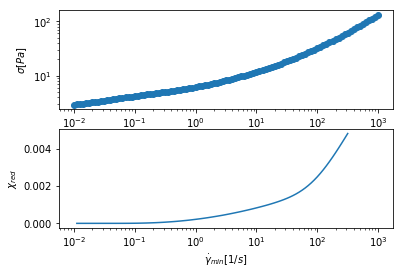

In [17]:
data=rheofit.rheodata.example_emulsion()
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def explore_redchi(res_fit,min_shear_rate=0.01,max_shear_rate=1000):
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    res_dict={min_shear:fit_range(res_fit,min_shear_rate=min_shear,max_shear_rate=1000) 
              for min_shear in data['Shear rate'][10:-1]}
    
    ax1= plt.subplot(2,1,1)
    
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\dot\gamma [1/s]$')
    plt.ylabel('$\sigma [Pa]$')

    ax2= plt.subplot(2,1,2,sharex = ax1)
    
    plt.plot(list(res_dict.keys()),pb.glance(res_dict)['redchi'])
    plt.xscale('log')
    plt.ylabel('$\chi_{red}$')
    plt.xlabel('$\dot\gamma_{min} [1/s]$')
    
    return plt.gcf()
    
explore_redchi(res_fit);

## Model parameter sensitivity on shear rate range

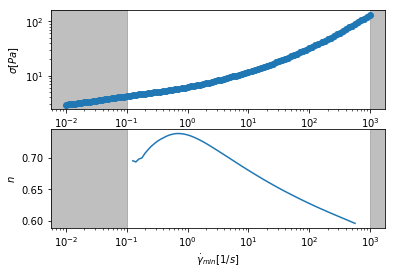

In [18]:
data=rheofit.rheodata.example_emulsion()
data.sort_values('Shear rate',ascending=False, inplace=True)

model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def explore_param_keephigh(res_fit,min_shear_rate=0.01,max_shear_rate=1000,param_name=None):
    '''keep the right range of data for the fit
    answer the question: how important it is how low we extend the analysis at low shear?
    '''
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    data.sort_values('Shear rate',ascending=False, inplace=True)
    res_fit=res_fit.model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))
    res_fit=fit_range(res_fit,min_shear_rate=min_shear_rate,max_shear_rate=max_shear_rate)
    res_dict={min_shear:fit_range(res_fit,min_shear_rate=min_shear,max_shear_rate=max(res_fit.userkws['x'])) 
              for min_shear in res_fit.userkws['x'][5:-1]}
    
    ax1= plt.subplot(2,1,1)
    
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\dot\gamma [1/s]$')
    plt.ylabel('$\sigma [Pa]$')
    
    xlim=plt.gca().get_xlim()
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)
    
    ax2= plt.subplot(2,1,2,sharex = ax1)
    
    plt.plot(list(res_dict.keys()),pb.tidy(res_dict)['value'][pb.tidy(res_dict)['name']=='HB_n'])
    plt.xscale('log')
    plt.ylabel('$'+param_name+'$')
    plt.xlabel('$\dot\gamma_{min} [1/s]$')
    
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)

    plt.gca().set_xlim(xlim)
    
    return plt.gcf()
    
explore_param_keephigh(res_fit,min_shear_rate=0.1,param_name='n');

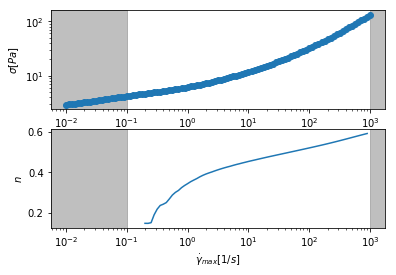

In [19]:
data=rheofit.rheodata.example_emulsion()
data.sort_values('Shear rate',ascending=False, inplace=True)

model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))


def explore_param_keeplow(res_fit,min_shear_rate=0.01,max_shear_rate=1001,param_name=None):
    '''keep the right range of data for the fit
    answer the question: how important it is how low we extend the analysis at low shear?
    '''
    
    data=pd.DataFrame.from_dict({'Shear rate':res_fit.userkws['x'],'Stress':res_fit.data})
    data.sort_values('Shear rate',ascending=True, inplace=True)
    res_fit=res_fit.model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']))
    res_fit=fit_range(res_fit,min_shear_rate=min_shear_rate,max_shear_rate=max_shear_rate)
    res_dict={max_shear:fit_range(res_fit,min_shear_rate=min(res_fit.userkws['x']),max_shear_rate=max_shear) 
              for max_shear in res_fit.userkws['x'][5:-1]}
    
    ax1= plt.subplot(2,1,1)
    
    plt.plot(data['Shear rate'],data['Stress'],'o')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\dot\gamma [1/s]$')
    plt.ylabel('$\sigma [Pa]$')
    
    xlim=plt.gca().get_xlim()
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)
    
    ax2= plt.subplot(2,1,2,sharex = ax1)
    
    plt.plot(list(res_dict.keys()),pb.tidy(res_dict)['value'][pb.tidy(res_dict)['name']=='HB_n'])
    plt.xscale('log')
    plt.ylabel('$'+param_name+'$')
    plt.xlabel('$\dot\gamma_{max} [1/s]$')
    
    plt.axvspan(xlim[0],min_shear_rate,color='gray',alpha=0.5)
    plt.axvspan(max_shear_rate,xlim[1],color='gray',alpha=0.5)

    plt.gca().set_xlim(xlim)
    
    return plt.gcf()
    
explore_param_keeplow(res_fit,min_shear_rate=0.1,param_name='n');

## Emcee

/usr/local/lib/python3.6/dist-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 1000/1000 [01:23<00:00, 12.12it/s]


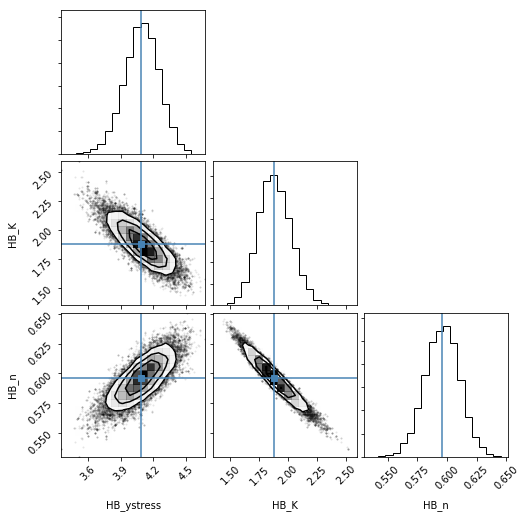

In [20]:
data=rheofit.rheodata.example_emulsion()
data=data[data['Shear rate']>0.1]
model=rheofit.models.HB_model
res_fit=model.fit(data['Stress'],x=data['Shear rate'],weights=1/(data['Stress']*0.1))
res_emcee=res_fit.emcee(steps=1000, nwalkers=50, burn=300)

corner.corner(res_emcee.flatchain, labels=res_emcee.var_names, truths=[res_fit.params[key].value for key in res_fit.params.keys()]);
display(res_fit)